## generate previous frames with pCO2 and fit it against ConvLSTM for multiple members

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-12-11 17:52:10.330125: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [90]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.13.5


In [2]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def custom_rmse2(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    + difference between sss
    """
    idx  = tf.not_equal(y_true, 0.0)
    idx2  = tf.equal(y_true, 0.0)
    
    y_pred1 = tf.boolean_mask(y_pred,idx)
    y_true1 = tf.boolean_mask(y_true,idx)
    y_true1 = tf.cast(y_true1, y_pred.dtype)
    
    rmse1 = K.sqrt(K.mean(tf.math.squared_difference(y_pred1, y_true1),axis= -1))
    
    #y_pred2 = tf.boolean_mask(y_pred,idx2)
    #loss2 = 10*(K.var(y_true1)/K.var(y_pred2))
    #loss2 = tf.cast(loss2, y_pred.dtype)
    
    return rmse1

## transfer learning on canESM


In [52]:
# CNN on CAN
cnn_model_path="../../models/base_model/u_net_dist.h5"
cnn_model = tf.keras.models.load_model(cnn_model_path, custom_objects={'custom_rmse':custom_rmse})

can_data_path = "../../data/can_001"


def read_xarray_can(dir_name=""):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature mpi
    '''
    date="198201-201712"
  
    file_type ="CanESM2r1r10"
    #Chl_2D_mon_CanESM2r1r10_1x1_198201-201712.nc
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_can(can_data_path)

chl_images = preprocess_image_reduced(chl.Chl.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)

def pco2_socat_preprocess(arr):
    tmp_arr=arr[arr!=0.0]
    coord = ((arr==0))
    min_pixel, max_pixel = np.nanmin(tmp_arr), np.nanmax(tmp_arr)
    
    output = (arr-min_pixel)*(255)/(max_pixel-min_pixel)
    output[coord]=0
    return output, min_pixel, max_pixel
        
pco2_socat_images,min_pixel,max_pixel = pco2_socat_preprocess(pco2.pCO2_socat.data)

dist_map = preprocess_image_reduced(dist_map)
    
X_tf = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
y_tf = pco2_socat_images
X_tf = X_tf.reshape((421,180,360,5),order='F')


In [53]:
def inverse_pco2_socat(arr,min_pixel,max_pixel=1000):
    y_pred = arr*(max_pixel-min_pixel)/255+min_pixel
    return y_pred


In [54]:
np.min(pco2_socat_images), np.max(pco2_socat_images), np.var(pco2_socat_images)

(0.0, 255.0, 15.047958921853581)

In [66]:
# without transfer learning performance
# y_tf=cnn_model.predict(X_tf)
# y_true,y_pred=inverse_scale_image(y_tf,pco2.pCO2.data)
# custom_rmse(y_true,y_pred)

In [55]:
# transfer learning
for layer in cnn_model.layers[:-8]:
    layer.trainable = False

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 32)      4032      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 64)       102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 40, 64)        0

In [56]:
from tensorflow.keras import backend as K

tf.keras.backend.clear_session()


myLearnRate=0.0002

cnn_model.compile(
    loss=custom_rmse2, optimizer=keras.optimizers.Adam(learning_rate=myLearnRate),
)

model_path="../../models/transfer_CNN_can.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = cnn_model.fit(X_tf,y_tf, epochs=50, 
                         validation_data=(X_tf,y_tf),
                         workers=-1,batch_size=32,
                         callbacks=callbacks)

Epoch 1/50
14/14 [==============================] - 4s 278ms/step - loss: 44.0966 - val_loss: 31.0340
Epoch 2/50
14/14 [==============================] - 3s 223ms/step - loss: 25.1269 - val_loss: 15.1887
Epoch 3/50
14/14 [==============================] - 3s 224ms/step - loss: 12.8846 - val_loss: 9.8422
Epoch 4/50
14/14 [==============================] - 3s 223ms/step - loss: 9.4748 - val_loss: 8.1183
Epoch 5/50
14/14 [==============================] - 3s 224ms/step - loss: 8.4762 - val_loss: 7.3875
Epoch 6/50
14/14 [==============================] - 3s 225ms/step - loss: 8.0213 - val_loss: 7.1119
Epoch 7/50
14/14 [==============================] - 3s 225ms/step - loss: 7.3383 - val_loss: 6.9244
Epoch 8/50
14/14 [==============================] - 3s 224ms/step - loss: 7.6186 - val_loss: 6.7853
Epoch 9/50
14/14 [==============================] - 3s 222ms/step - loss: 7.5893 - val_loss: 6.7863
Epoch 10/50
14/14 [==============================] - 3s 224ms/step - loss: 7.3803 - val_loss: 6

In [69]:
#cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_2.h5', custom_objects={'custom_rmse':custom_rmse})
cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_can.h5', custom_objects={'custom_rmse2':custom_rmse2})


predicted_image = cnn_model.predict(X_tf,verbose=1)

chl,mld,sss,sst,xco2,pco2 = read_xarray_can(can_data_path)
coord = ((pco2.pCO2.data==0.0) | (pco2.pCO2.data>1000))
predicted_image[coord] = 0

full_truth = pco2.pCO2.data
full_truth[coord] = 0

14/14 [==============================] - 1s 70ms/step


In [70]:
inv_predicted_image=inverse_pco2_socat(predicted_image,min_pixel,max_pixel)

In [60]:
custom_rmse(inv_predicted_image,full_truth)

<tf.Tensor: shape=(), dtype=float32, numpy=54.803608>

/tmp/ipykernel_887263/1144098214.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.arange(280,440,20))
/tmp/ipykernel_887263/1144098214.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.set_ticklabels(np.arange(280,440,20))


Text(0.5, 0.98, 'Average canESM Transfer Learning pCO2 | Prediction | Residual - over 1987/02-2017/01')

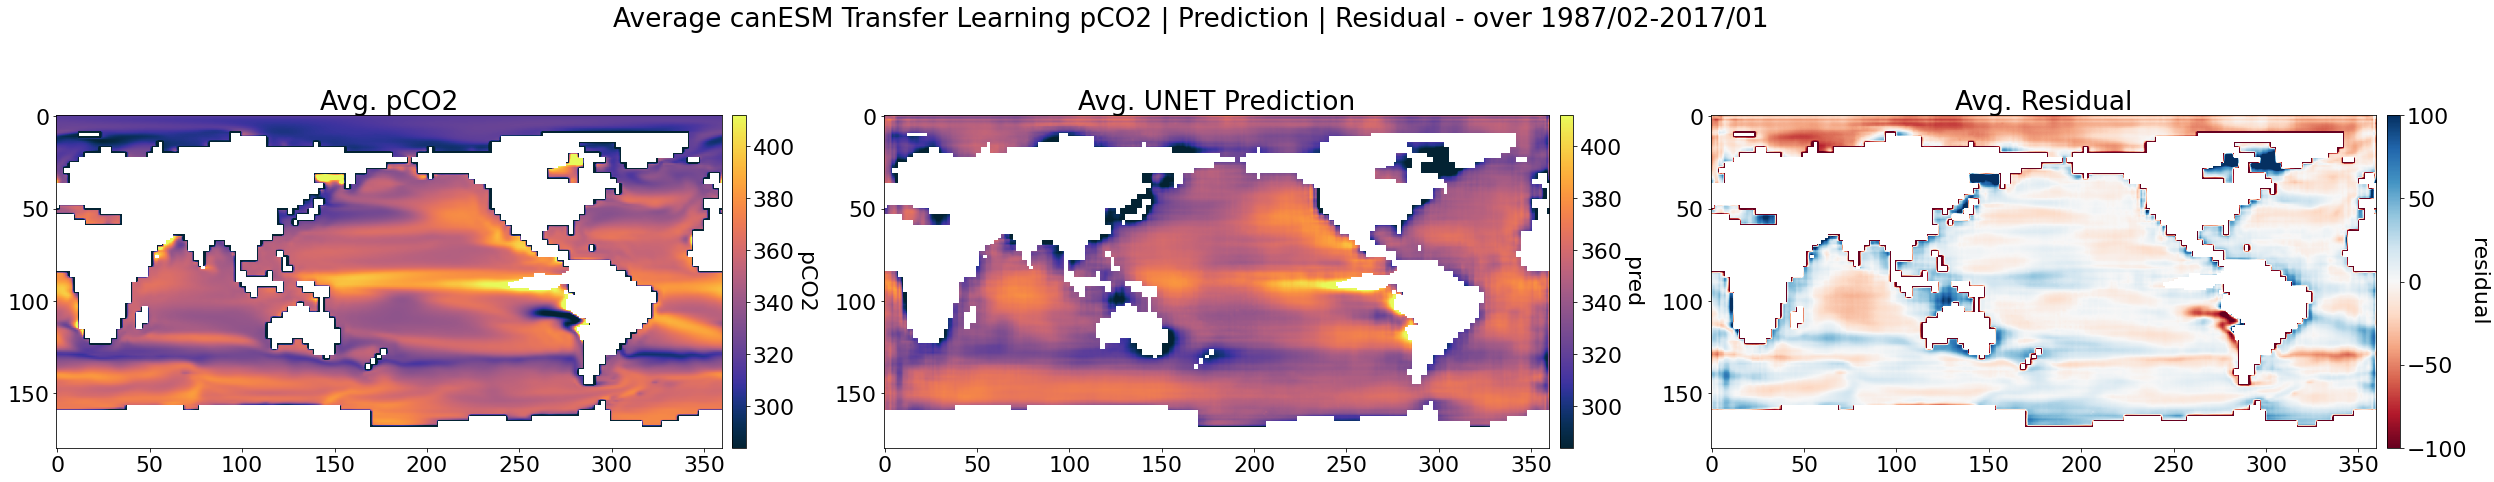

In [65]:
# CNN average Image
full_truth[coord] = np.nan
inv_predicted_image[coord] = np.nan

res_unet = full_truth - inv_predicted_image

avg_y_true = np.mean(full_truth,axis=0)
avg_y_pred = np.mean(inv_predicted_image,axis=0)
avg_res = np.mean(res_unet,axis=0)

import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im0 = axis[0].imshow(np.flipud(avg_y_true),cmap = cm.cm.thermal,norm=norm,label="pCO2")
axis[0].set_title("Avg. pCO2")

divider = make_axes_locatable(axis[0])
cax = divider.append_axes('right', size='2%', pad=0.15)
cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('pCO2', rotation=270)
cbar.set_ticklabels(np.arange(280,440,20))


im1 =axis[1].imshow(np.flipud(avg_y_pred),cmap = cm.cm.thermal,norm=norm,label="pCO2 pred")
axis[1].set_title("Avg. UNET Prediction")

divider = make_axes_locatable(axis[1])
cax = divider.append_axes('right', size='2%', pad=0.15)
cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
cbar2.ax.get_yaxis().labelpad = 20
cbar2.ax.set_ylabel('pred', rotation=270)
cbar2.set_ticklabels(np.arange(280,440,20))


im2=axis[2].imshow(np.flipud(avg_res),cmap = "RdBu",norm=norm2,label="residual")
axis[2].set_title("Avg. Residual")

divider = make_axes_locatable(axis[2])
cax = divider.append_axes('right', size='2%', pad=0.15)
cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
cbar3.ax.get_yaxis().labelpad = 20
cbar3.ax.set_ylabel('residual', rotation=270)
#cbar3.set_ticklabels(np.arange(-100,100,25))


figure.suptitle("Average canESM Transfer Learning pCO2 | Prediction | Residual - over 1987/02-2017/01")

#plt.savefig("../../assets/figure6.0_unet_canESM.jpg")

In [78]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3)
X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,inv_predicted_image))
X = X.reshape((421,180,360,6),order='F')
X = X[X_index][:-1]

y_tf=np.expand_dims(y_tf[X_index][1:],axis=4)

In [79]:
X.shape, y_tf.shape # changed sliding

((418, 3, 180, 360, 6), (418, 3, 180, 360, 1))

In [80]:
tf.keras.backend.clear_session()

convlstm_model_path = "../../models/ConvLSTM_with_pco2_2.h5"

convlstm_model = tf.keras.models.load_model(convlstm_model_path, custom_objects={'custom_rmse':custom_rmse})


In [81]:
chl,mld,sss,sst,xco2,pco2t2 = read_xarray_can(can_data_path)

tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][1:])
y_true_full = np.expand_dims(tmp,axis=4)
y_true_full.shape

coord = ((y_true_full==0.0)|(y_true_full>1000.0))

predicted_frames= convlstm_model.predict(X,verbose=1)
predicted_frames[coord] = 0

print("ConvLSTM Full RMSE score w/o finetuning:")
a=custom_rmse(predicted_frames[:,1:2],y_true_full[:,1:2])
print(a)



14/14 [==============================] - 15s 1s/step
ConvLSTM Full RMSE score w/o finetuning:
tf.Tensor(100.94962, shape=(), dtype=float32)


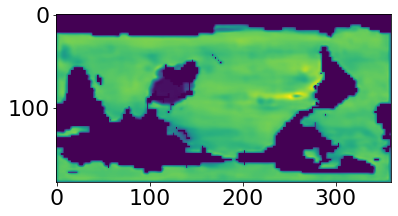

In [82]:
plt.imshow(predicted_frames[0][0])

In [83]:
for layer in convlstm_model.layers[:-2]:
    layer.trainable = False

convlstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8

In [84]:
convlstm_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

model_path="../../models/transfer_CNN_LSTM_can.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 16

In [85]:
history = convlstm_model.fit(
    X,
    y_tf,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X, y_tf),
    callbacks=callbacks,
)

Epoch 1/50
27/27 [==============================] - 45s 2s/step - loss: 159.2104 - val_loss: 54.6783
Epoch 2/50
27/27 [==============================] - 37s 1s/step - loss: 41.5292 - val_loss: 14.8974
Epoch 3/50
27/27 [==============================] - 37s 1s/step - loss: 10.6842 - val_loss: 5.9534
Epoch 4/50
27/27 [==============================] - 37s 1s/step - loss: 6.0479 - val_loss: 5.2637
Epoch 5/50
27/27 [==============================] - 37s 1s/step - loss: 5.5335 - val_loss: 4.9659
Epoch 6/50
27/27 [==============================] - 37s 1s/step - loss: 5.2056 - val_loss: 4.8120
Epoch 7/50
27/27 [==============================] - 37s 1s/step - loss: 5.0177 - val_loss: 4.6989
Epoch 8/50
27/27 [==============================] - 37s 1s/step - loss: 5.1234 - val_loss: 4.6468
Epoch 9/50
27/27 [==============================] - 37s 1s/step - loss: 4.9126 - val_loss: 4.5520
Epoch 10/50
27/27 [==============================] - 37s 1s/step - loss: 4.8334 - val_loss: 4.5118
Epoch 11/50
2

KeyboardInterrupt: 

In [86]:
chl,mld,sss,sst,xco2,pco2t2 = read_xarray_can(can_data_path)

tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][1:])
y_true_full = np.expand_dims(tmp,axis=4)
y_true_full.shape
coord = ((y_true_full==0.0)|(y_true_full>1000.0))



In [88]:
tf_model = tf.keras.models.load_model("../../models/transfer_CNN_LSTM_can.h5", custom_objects={'custom_rmse':custom_rmse})

predicted_frames= tf_model.predict(X,verbose=1)
inv_predicted_frames = inverse_pco2_socat(predicted_frames,min_pixel,max_pixel)
inv_predicted_frames[coord] = 0

print("Full RMSE score:")
a=custom_rmse(inv_predicted_frames[:,1:2],y_true_full[:,1:2])
print(a)


14/14 [==============================] - 15s 1s/step
Full RMSE score:
tf.Tensor(52.801025, shape=(), dtype=float32)


/tmp/ipykernel_887263/2112058642.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.arange(280,440,20))
/tmp/ipykernel_887263/2112058642.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.set_ticklabels(np.arange(280,440,20))


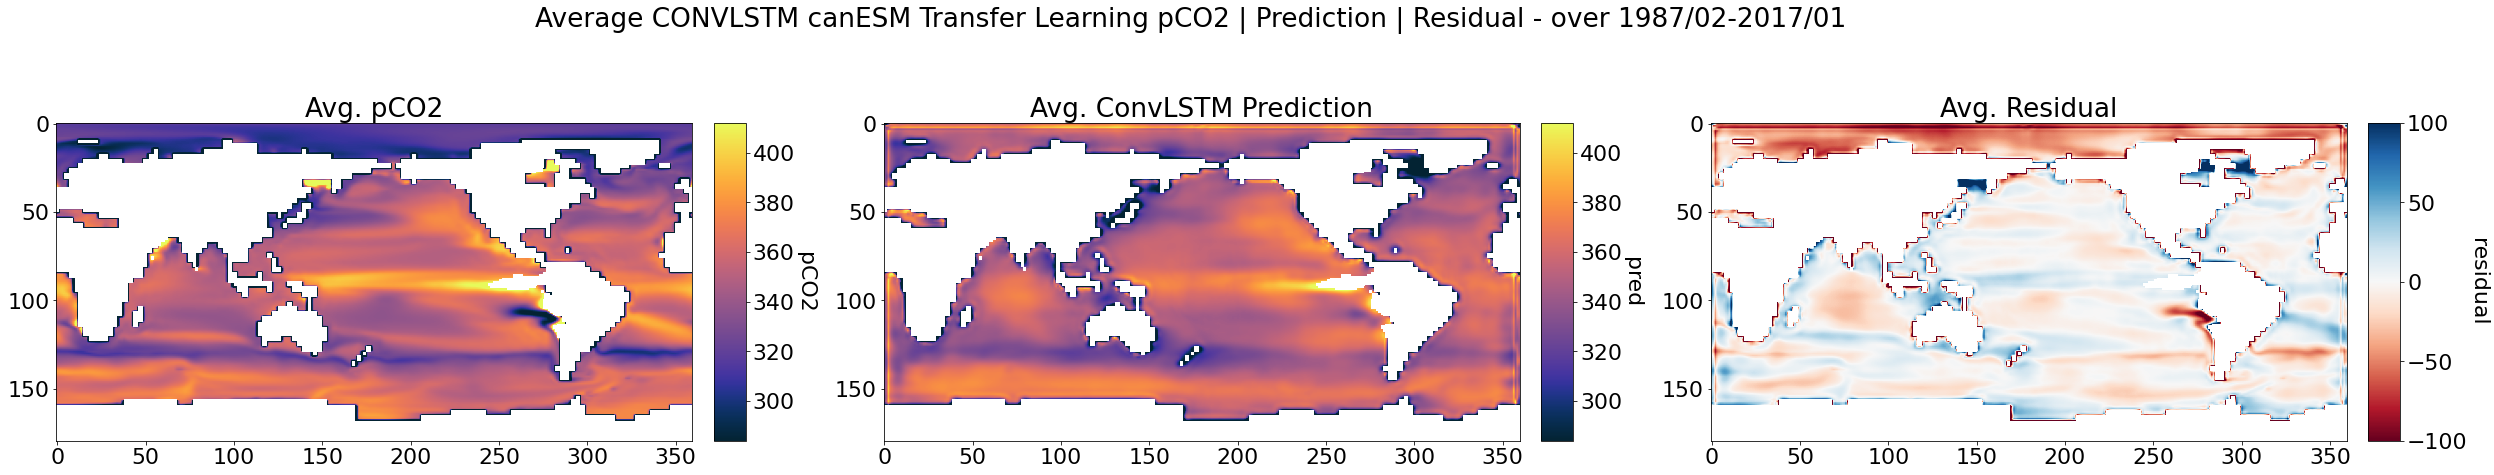

In [89]:
# ConvLSTM average Image
import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
inv_predicted_frames[coord] = np.nan
y_true_full[coord] = np.nan
avg_y_pred = np.mean(inv_predicted_frames[:,1:2],axis=0)
avg_y_true = np.mean(y_true_full[:,1:2],axis=0)

res = y_true_full[:,1:2]-inv_predicted_frames[:,1:2]
avg_res = np.mean(res,axis=0)
figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im0 = axis[0].imshow(np.flipud(avg_y_true[0]),cmap = cm.cm.thermal,norm=norm,label="pCO2")
axis[0].set_title("Avg. pCO2")

divider = make_axes_locatable(axis[0])
cax = divider.append_axes('right', size='5%', pad=0.3)
cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('pCO2', rotation=270)
cbar.set_ticklabels(np.arange(280,440,20))

im1 =axis[1].imshow(np.flipud(avg_y_pred[0]),cmap = cm.cm.thermal,norm=norm,label="pCO2 pred")
axis[1].set_title("Avg. ConvLSTM Prediction")

divider = make_axes_locatable(axis[1])
cax = divider.append_axes('right', size='5%', pad=0.3)
cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
cbar2.ax.get_yaxis().labelpad = 20
cbar2.ax.set_ylabel('pred', rotation=270)
cbar2.set_ticklabels(np.arange(280,440,20))

im2=axis[2].imshow(np.flipud(avg_res[0]),cmap = "RdBu",norm=norm2,label="residual")
axis[2].set_title("Avg. Residual")

divider = make_axes_locatable(axis[2])
cax = divider.append_axes('right', size='5%', pad=0.3)
cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
cbar3.ax.get_yaxis().labelpad = 20
cbar3.ax.set_ylabel('residual', rotation=270)
#cbar3.set_ticklabels(np.arange(-100,100,20))
               
figure.suptitle("Average CONVLSTM canESM Transfer Learning pCO2 | Prediction | Residual - over 1987/02-2017/01")

plt.savefig("../../assets/figure6.0_convlstm_canESM.jpg")

(418, 180, 360, 1)
(418,)


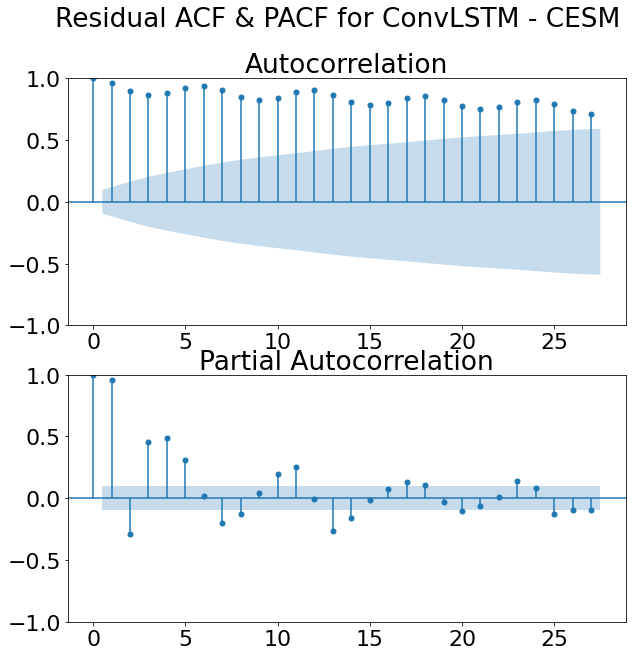

In [95]:
y_true_full[coord]=np.nan
inv_predicted_frames[coord]=np.nan

res = y_true_full[:,2]-inv_predicted_frames[:,2]

print(res.shape)


avg_time_res_convlstm=np.nanmean(res, axis=(1,2,3))
print(avg_time_res_convlstm.shape)

fig = pyplot.figure(figsize = (10,10))
pyplot.subplot(211)
plot_acf(avg_time_res_convlstm, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(avg_time_res_convlstm, ax=pyplot.gca())

fig.suptitle("Residual ACF & PACF for ConvLSTM - CESM")

plt.savefig("../../assets/figure7_convLSTM_can_acf_3mon.jpg")
pyplot.show()

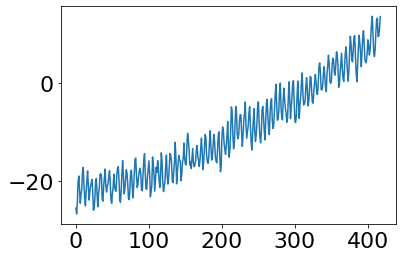

In [96]:
plt.plot(avg_time_res_convlstm)